In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import gc

from argparse import Namespace
from mimetypes import suffix_map
from pathlib import Path
import numpy as np
import yaml

import torch
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.trainer import Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

from turboflow.datasets.turb2D import Turb2D
from turboflow.quick_train import train

from turboflow.utils import phy_utils as phy
from turboflow.utils import dsp_utils as dsp
from turboflow.utils import torch_utils as tch
from turboflow.utils import viz_utils as viz 
from turboflow.utils import file_utils as fle

import matplotlib.pyplot as plt
import cmocean

In [3]:
base_dir = Path('/','home','dicarlo_d','Documents','Code','TurboSuperResultion','recipes','report_cominlabs_march2022')
data_dir = Path('/','home','dicarlo_d','Documents','Datasets','Turb2D.hdf5')
fig_path = base_dir / Path('figures')
res_path = base_dir / Path('results')

base_dir.mkdir(parents=True, exist_ok=True)
base_dir.exists()

fig_path.mkdir(parents=True, exist_ok=True)
res_path.mkdir(parents=True, exist_ok=True)

()
(256, 256, 2)
(256, 256, 2)


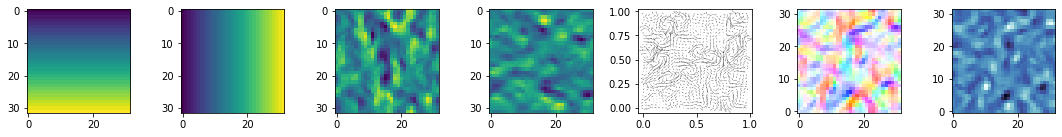

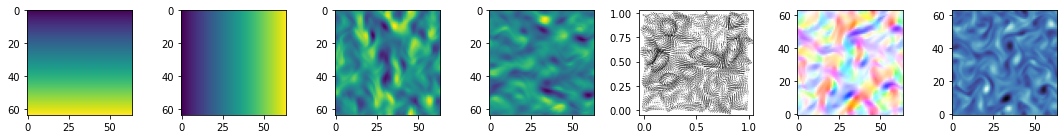

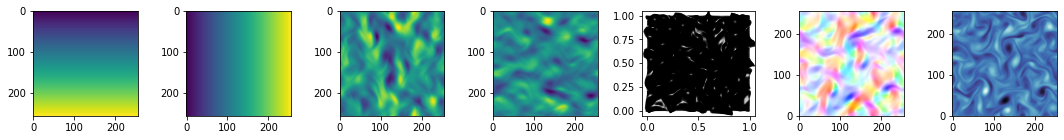

In [17]:
time_idx = 862
tb = Turb2D(data_dir)
tb.load_data(time_idx)

# Data in Turb2D are (T,R,R,D)
t = tb.t
xy = tb.xy
uv = tb.uv

print(t.shape)
print(xy.shape)
print(uv.shape)

# normalize y
uv = uv/np.max(np.abs(uv))
assert np.min(uv) >= -1
assert np.max(uv) <=  1

data = {
    'ongrid' : {
        'lr' : {'xy' : xy[::8,::8,:].reshape(-1,2), 
                'uv' : uv[::8,::8,:].reshape(-1,2), 
                'R'  : xy[::8,::8,:].shape[0]},
        'mr' : {'xy' : xy[::4,::4,:].reshape(-1,2), 
                'uv' : uv[::4,::4,:].reshape(-1,2), 
                'R'  : xy[::4,::4,:].shape[0]},
        'hr' : {'xy' : xy[::1,::1,:].reshape(-1,2), 
                'uv' : uv[::1,::1,:].reshape(-1,2), 
                'R'  : xy[::1,::1,:].shape[0]},
    }
}

for res in ['lr', 'mr', 'hr']:
    R = data['ongrid'][res]['R']
    x = data['ongrid'][res]['xy'][...,0].reshape(R,R)
    y = data['ongrid'][res]['xy'][...,1].reshape(R,R)
    u = data['ongrid'][res]['uv'][...,0].reshape(R,R)
    v = data['ongrid'][res]['uv'][...,1].reshape(R,R)
    
    plt.figure(figsize=(15,2))
    plt.subplot(171)
    plt.imshow(x)
    plt.subplot(172)
    plt.imshow(y)
    plt.subplot(173)
    plt.imshow(u)
    plt.subplot(174)
    plt.imshow(v)
    
    plt.subplot(175)
    plt.quiver(x, y, u, v, scale=10, alpha=0.8)
    
    plt.subplot(176)
    img = viz.flow_to_image(data['ongrid'][res]['uv'].reshape(R,R,2))
    plt.imshow(img, origin='lower')
    
    plt.subplot(177)
    w = phy.compute_vorticity((x, y), (u, v))
    plt.imshow(w, origin='lower', cmap=cmocean.cm.ice)
    
    plt.tight_layout()
    plt.show()

(512, 512)
1.0
1.0
(262144, 2)
(262144, 2)


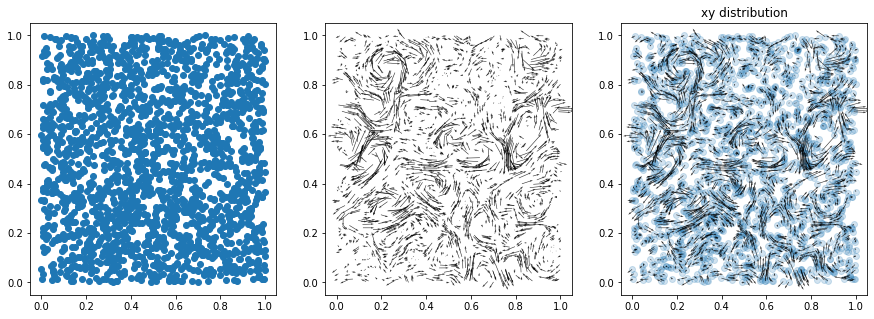

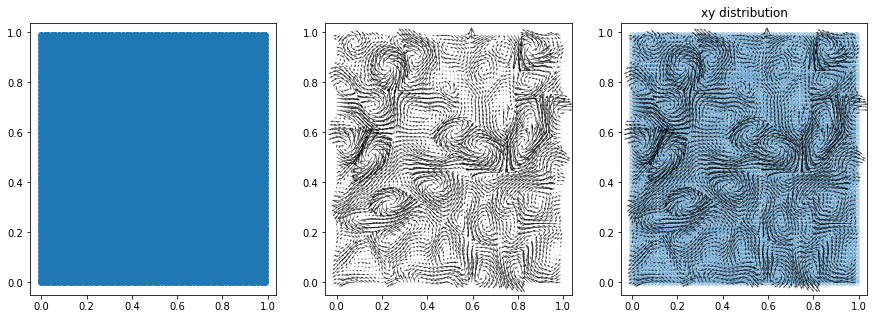

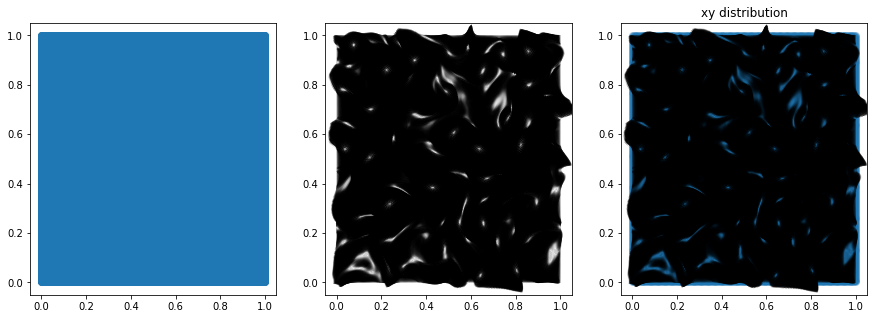

In [23]:
s=2
u_smp, xy_smp = dsp.interpolate2D_mesh01x01(xy, uv[:,:,0], scale=s)
v_smp, xy_smp = dsp.interpolate2D_mesh01x01(xy, uv[:,:,1], scale=s)

print(u_smp.shape)

xy_smp = np.stack([xy_smp[:,:,1], xy_smp[:,:,0]], axis=-1)
uv_smp = np.stack([u_smp, v_smp], axis=-1)


R_smp = uv_smp.shape[0]
xy_smp = xy_smp.reshape(R_smp**2, 2)
uv_smp = uv_smp.reshape(R_smp**2, 2)

uv_smp = uv_smp/np.max(np.abs(uv_smp))

max_res = 256

# # subsample for TEST
# ppp_test = 0.07
# N_test = int((max_res**2) * ppp_test)
# idx_test = np.random.randint(0, R_smp**2, size=N_test)

ppp_train = 0.03
N_train = int((max_res**2)*ppp_train)
idx_train = np.random.randint(0, R_smp**2, size=N_train)

data['offgrid'] = {
    'lr' : {'xy' :  xy_smp[idx_train,:], 
            'uv' : uv_smp[idx_train,:], 
            'R' : idx_train.shape[0]},
    'mr' : data['ongrid']['mr'],
    'hr' : data['ongrid']['hr']
}


for res in ['lr', 'mr', 'hr']:
    x = data['offgrid'][res]['xy'][...,0]
    y = data['offgrid'][res]['xy'][...,1]
    u = data['offgrid'][res]['uv'][...,0]
    v = data['offgrid'][res]['uv'][...,1]
    
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.scatter(x, y)
    plt.subplot(132)
    plt.quiver(x[::ds], y[::ds], u[::ds], v[::ds], scale=10, alpha=0.8)

    plt.subplot(133)
    plt.title('xy distribution')
    plt.scatter(x, y, alpha=0.2)
    ds = 1
    plt.quiver(x[::ds], y[::ds], u[::ds], v[::ds], scale=10, alpha=0.8)
    plt.show()

In [6]:
class MyDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, X, y):

        assert np.max(np.abs(y)) <= 1
        assert np.max(np.abs(X)) <= 1

        'Initialization'
        print('X shape', X.shape)
        print('y shape', y.shape)
        try:
            assert X.shape[0] == y.shape[0]
            assert X.shape[1] == y.shape[1]
        except:
            print('*** Dimension error ***')
            print('X', X.shape)
            print('y', y.shape)
            
        H, Cin = X.shape
        H, Cout = y.shape
        
        # reshape s.t. B = H*W of query points
        X = X.reshape(H, Cin)
        y = y.reshape(H, Cout)
        
        self.size = H
        # convert to torch and add an empty dimension for the batch
        self.inputs = torch.from_numpy(X).float() #XY x 2 (x,y)
        self.target = torch.from_numpy(y).float()  #XxYx3 (RGB)
        
        assert self.inputs.shape[0] == self.target.shape[0]
        assert self.inputs.shape[1] == self.target.shape[1]
        
        print(self.inputs.shape)
        print(self.inputs.shape)

    def __len__(self):
        'Denotes the total number of samples'
        return self.size

    def __getitem__(self, idx):
        'Generates one sample of data'
        # Load data and get label
        X = self.inputs[idx,...]
        y = self.target[idx,...]

        return X, y


class DataModule(pl.LightningDataModule):
    def __init__(self, train_data, val_data, test_data):
        
        super().__init__()
        self.train_data = train_data
        self.test_data = test_data
        self.val_data = val_data
        self.batch_size = 125
        self.num_workers = 1
        
    def prepare_data(self):
        self.train_dataset = MyDataset(self.train_data[0], self.train_data[1])
        self.val_dataset = MyDataset(self.val_data[0], self.val_data[1])
        self.test_dataset = MyDataset(self.test_data[0], self.test_data[1])
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, 
                          self.batch_size, num_workers = self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, 
                          self.batch_size, num_workers = self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, 
                          self.batch_size, num_workers = self.num_workers)
    

dm = {}
for case in ['offgrid', 'ongrid']:
    print(case)
    dm[case] = DataModule(
        train_data= [data[case]['lr']['xy'], data[case]['lr']['uv']],
        val_data  = [data[case]['mr']['xy'], data[case]['mr']['uv']],
        test_data = [data[case]['hr']['xy'], data[case]['hr']['uv']],
    )

    dm[case].prepare_data()

offgrid
X shape (1966, 2)
y shape (1966, 2)
torch.Size([1966, 2])
torch.Size([1966, 2])
X shape (1966, 2)
y shape (1966, 2)
torch.Size([1966, 2])
torch.Size([1966, 2])
X shape (4587, 2)
y shape (4587, 2)
torch.Size([4587, 2])
torch.Size([4587, 2])
ongrid
X shape (1024, 2)
y shape (1024, 2)
torch.Size([1024, 2])
torch.Size([1024, 2])
X shape (1024, 2)
y shape (1024, 2)
torch.Size([1024, 2])
torch.Size([1024, 2])
X shape (65536, 2)
y shape (65536, 2)
torch.Size([65536, 2])
torch.Size([65536, 2])


In [11]:
case = 'ongrid'

model = {
    'name' : 'MFN' # 'RFFMLP
,   'cnn' : False
,   'do_divfree' : False
}

exp_suffix = f'{model["name"]}_1x32x32_divfree:{model["do_divfree"]}_'

hparams = {
    'name': model['name'],
    'do_time' : False,
    'do_cnn' : model['cnn'],
    'mlp_layers_num': 1,
    'mlp_layers_dim': 32, 
    'mlp_last_actfn': 'tanh',
    'rff_num_space': 128,
    'rff_scale_space': 10,
    'rff_num_time': 64, 
    'rff_scale_time': 1,
    'do_divfree': model['do_divfree'],
    'lam_sdiv': 0, 
    'lam_sfn':  0,    
    'lam_spec': 0,    
    'lam_grads':0,    
    'lam_curl' :0,    
    'lam_pde' : 0,
    'lam_weight': 1e-5,  # L2 reg on the NN's weights
    'sfn_min_x': 1./256., # maximal resolution
    'sfn_num_centers': 32,
    'sfn_num_increments':8,
    'sfn_patch_dim': 16 # (P/2)
}

from turboflow.models.phyrff import plDivFreeRFFNet

model = plDivFreeRFFNet(**vars(Namespace(**hparams)))

early_stop_callback = EarlyStopping(monitor='val/loss/tot')
checkpoint_callback = ModelCheckpoint(
    monitor="val/loss/tot",
    dirpath=".torch_checkpoints",
    filename="Turb2D-%s-{epoch:02d}-{val_loss:.4f}" % (hparams['name']),
    save_top_k=1,
    mode="min",
)

trainer = Trainer(gpus=1,
                  max_epochs=2000, 
                  log_every_n_steps=20,
                  check_val_every_n_epoch=50, 
                  callbacks=[early_stop_callback,
                             checkpoint_callback])

trainer.fit(model, dm[case])

# perf = trainer.test(model, dm)
# path = checkpoint_callback.best_model_path
# vers =  f'version_{trainer.logger.version}'
# res_dict = {
#     'metrics' : perf,
#     'path' : path,
#     'hparams' : hparams,
#     'pl_version' : vers,
# }


# out_file = 'lxlaser2022/Turb2D_%s.pkl' % vers
# fle.save_obj(res_dict, out_file)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type            | Params
----------------------------------------------
0 | rff_time  | Fourier         | 64    
1 | rff_space | Fourier         | 256   
2 | mfn       | GaborNet        | 338 K 
3 | sp_grad   | SpatialGradient | 0     
4 | sp_lapl   | Laplacian       | 0     
----------------------------------------------
338 K     Trainable params
320       Non-trainable params
339 K     Total params
1.356     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:326: UserWarning: The number of training samples (9) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
model, best_model_path, hparams = train(exp_suffix, data_dir, hparams, train_params)
print(best_model_path.split('/')[-1])

In [ ]:
results = {
    'exp_name' : exp_suffix
,   'best_model_path' : best_model_path
,   'hparams' : hparams
}

results_path = res_path / Path(f'results_{exp_suffix}.yaml')
with open(results_path, 'w') as file:

    outputs = yaml.dump(results, file)

print('Done.')

TypeError: max() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (Tensor other)
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


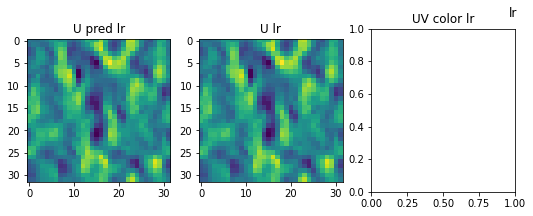

In [47]:
for res in ['lr','mr','hr']:

    R = data['ongrid'][res]['R']
#     patch_ln = torch.linspace(0, 1, R)
#     # make it square meshgrid
#     patch_sq = torch.stack(torch.meshgrid(patch_ln, patch_ln), dim=-1)
#     xy = patch_sq.view(-1,2)
    
    xy = torch.from_numpy(data['ongrid'][res]['xy']).view(-1,2)
    model.double()
    uv_pred = model(xy)[0]
    
    uv = torch.from_numpy(data['ongrid'][res]['uv']).view(-1,2)

    x = xy.reshape(R,R,2).detach().cpu().numpy()[:,:,0]
    y = xy.reshape(R,R,2).detach().cpu().numpy()[:,:,1]
    u_pred = uv_pred.reshape(R,R,2).detach().cpu().numpy()[:,:,0]
    v_pred = uv_pred.reshape(R,R,2).detach().cpu().numpy()[:,:,1]
    
    u = uv.reshape(R,R,2).detach().cpu().numpy()[:,:,0]
    v = uv.reshape(R,R,2).detach().cpu().numpy()[:,:,1]
    

    plt.figure(figsize=(18,3))
    plt.suptitle(f'{res}')
    plt.subplot(161)
    plt.title(f'U {res}')
    plt.imshow(u)
    plt.subplot(162)
    plt.title(f'U pred {res}')
    plt.imshow(u_pred)
    plt.subplot(163)
    plt.title(f'UV color {res}')
    img = viz.flow_to_image(uv_pred.reshape(R,R,2))
    plt.imshow(img, origin='lower')
    plt.subplot(164)
    plt.title(f'UV color {res}')
    img = viz.flow_to_image(uv.reshape(R,R,2))
    plt.imshow(img, origin='lower')
    plt.subplot(165)
    w = phy.compute_vorticity((x, y), (u, v))
    plt.imshow(w, origin='lower', cmap=cmocean.cm.ice)
    plt.tight_layout()
    plt.show()
    plt.subplot(166)
    w = phy.compute_vorticity((x, y), (u_pred, v_pred))
    plt.imshow(w, origin='lower', cmap=cmocean.cm.ice)
    plt.tight_layout()
    plt.show()



# s = 1
# plt.figure(figsize=(30,10))
# plt.subplot(131)
# R = data['ongrid'][res]['R']
# plt.quiver(data['ongrid'][res]['xy'].reshape(R,R,2)[::s,::s, 0], 
#            data['ongrid'][res]['xy'].reshape(R,R,2)[::s,::s, 1],
#            data['ongrid'][res]['uv'].reshape(R,R,2)[::s,::s, 0],
#            data['ongrid'][res]['uv'].reshape(R,R,2)[::s,::s, 1], scale=10)
# plt.subplot(132)
# plt.quiver(data['offgrid'][res]['xy'][::s, 0], 
#            data['offgrid'][res]['xy'][::s, 1],
#            data['offgrid'][res]['uv'][::s, 0],
#            data['offgrid'][res]['uv'][::s, 1], scale=10)
# plt.subplot(133)
# plt.quiver(x[::s,::s], y[::s,::s],
#            u[::s,::s], v[::s,::s], scale=10)